In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import GPy
from BNN_Dropout import NN_Dropout, BNN_Dropout
from Benchmark import RandomNN
from pybnn.bohamiann import Bohamiann

plt.rcParams['figure.figsize'] = (12.0, 8)


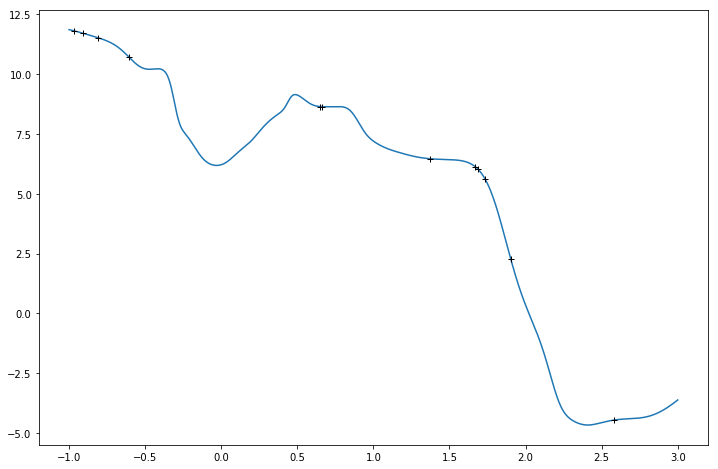

In [34]:
bench = RandomNN(1,3,50,nn.Tanh())
bench.rand_normal_weight(1)
num_plot  = 1000
num_train = 12
x = torch.linspace(-1,3,num_plot)[:,None]
y = bench(x)
train_id = np.random.permutation(num_plot)[:num_train]
train_x = x[train_id]
train_y = y[train_id]
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')

In [35]:
conf = dict()
conf['num_epochs'] = 1600
conf['num_hidden'] = 50
conf['num_layers'] = 1
conf['batch_size'] = 128


conf['dropout_rate'] = 0.01
conf['lr']           = 10 ** (-1.62)
conf['tau']          = 10 ** (-1.24)
conf['lscale']       = 10 ** (-2.0)



model = BNN_Dropout(1,nn.ReLU(), conf)
hmc_model = Bohamiann(print_every_n_steps=100)
kern = GPy.kern.RBF(input_dim = 1)
gp = GPy.models.GPRegression(X=train_x.numpy(), Y= train_y.detach().numpy(), kernel=kern)
gp.likelihood.variance = 1e-2

In [36]:
hmc_model.train(train_x.numpy(), train_y.detach().numpy(), num_steps=3000, num_burn_in_steps=2000, keep_every=50, lr=1e-2, verbose=True)
model.train(train_x, train_y)
gp.optimize()

Step      100 : NLL =  9.2738e+02 MSE = 3.9977e+01 Time =  0.82
Step      200 : NLL =  1.1494e+03 MSE = 4.0527e+01 Time =  1.61
Step      300 : NLL =  1.3846e+03 MSE = 4.0009e+01 Time =  2.41
Step      400 : NLL =  1.7513e+03 MSE = 4.0418e+01 Time =  3.18
Step      500 : NLL =  2.1279e+03 MSE = 4.0111e+01 Time =  4.01
Step      600 : NLL =  2.6002e+03 MSE = 4.0220e+01 Time =  4.98
Step      700 : NLL =  3.1924e+03 MSE = 4.0156e+01 Time =  5.83
Step      800 : NLL =  3.8909e+03 MSE = 4.0304e+01 Time =  6.71
Step      900 : NLL =  4.8059e+03 MSE = 4.0173e+01 Time =  7.57
Step     1000 : NLL =  5.9245e+03 MSE = 4.0547e+01 Time =  8.51
Step     1100 : NLL =  7.1999e+03 MSE = 4.0736e+01 Time =  9.27
Step     1200 : NLL =  8.6155e+03 MSE = 4.0433e+01 Time = 10.04
Step     1300 : NLL =  1.0529e+04 MSE = 4.0417e+01 Time = 10.82
Step     1400 : NLL =  1.2741e+04 MSE = 4.0296e+01 Time = 11.59
Step     1500 : NLL =  1.5962e+04 MSE = 4.0352e+01 Time = 12.39
Step     1600 : NLL =  1.9453e+04 MSE = 

 /mnt/c/code/pybnn/pybnn/bohamiann.py:119: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step     2100 : NLL =  4.3021e+04 MSE = 4.0093e+01 Samples= 1 Time = 16.88
Step     2200 : NLL =  5.3096e+03 MSE = 3.9873e+01 Samples= 3 Time = 17.52
Step     2300 : NLL =  6.5799e+03 MSE = 4.0015e+01 Samples= 5 Time = 18.17
Step     2400 : NLL =  7.8158e+03 MSE = 4.0081e+01 Samples= 7 Time = 18.87
Step     2500 : NLL =  7.0631e+03 MSE = 4.0185e+01 Samples= 9 Time = 19.60
Step     2600 : NLL =  6.7487e+03 MSE = 4.0292e+01 Samples= 11 Time = 20.27
Step     2700 : NLL =  7.2131e+03 MSE = 4.0323e+01 Samples= 13 Time = 20.94
Step     2800 : NLL =  7.9283e+03 MSE = 4.0328e+01 Samples= 15 Time = 21.68
Step     2900 : NLL =  8.6370e+03 MSE = 4.0341e+01 Samples= 17 Time = 22.31
After 100 epochs, loss is 0.0102412
After 200 epochs, loss is 0.0121608
After 300 epochs, loss is 0.00554605
After 400 epochs, loss is 0.00476177
After 500 epochs, loss is 0.00749875
After 600 epochs, loss is 0.00535341
After 700 epochs, loss is 0.00496261
After 800 epochs, loss is 0.00492053
After 900 epochs, loss is 0

Text(0.5,1,'Gaussian process')

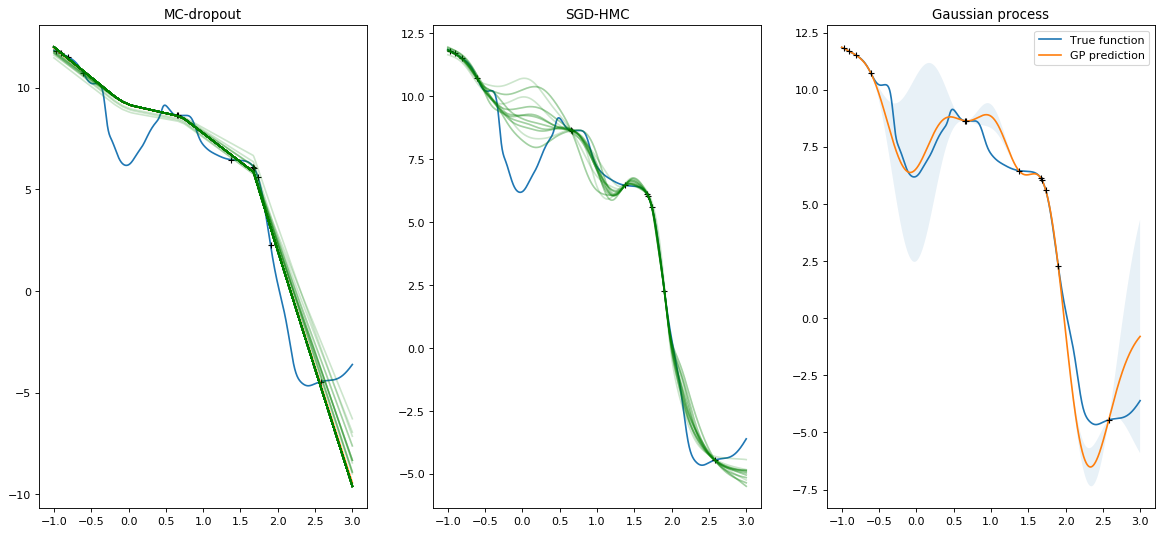

In [37]:
py = model.predict(x)
_,_,hmc_py = hmc_model.predict(x.numpy(), return_individual_predictions=True)
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')


plt.subplot(131)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(),py.detach().numpy(),label = 'Pred')
for i in range(100):
    net = model.sample()
    py  = net((x - model.x_mean) / model.x_std) * model.y_std + model.y_mean
    plt.plot(x.numpy(),py.detach().numpy(), 'g', alpha = 0.2)
plt.title('MC-dropout')

plt.subplot(132)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(), hmc_py.T, 'g', alpha = 0.2)
plt.title('SGD-HMC')

plt.subplot(133)
gp_m, gp_v = gp.predict(x.numpy())
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')
plt.plot(x.numpy(), gp_m, label = 'GP prediction')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), (gp_m - np.sqrt(gp_v)).reshape(num_plot), (gp_m + np.sqrt(gp_v)).reshape(num_plot), alpha = 0.1)
plt.legend()
plt.title('Gaussian process')